## AdamW benchmarking

This is to benchmark an implementation of https://arxiv.org/abs/1711.05101

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import fastai.optim.adamw as adamwlib
import fastai.optim.sgdw as sgdwlib
import matplotlib.pyplot as plt
%matplotlib inline

### Common stuff for all experiments

In [3]:
def Get_SGD_Momentum(momentum=0.9):
    return lambda *args, **kwargs: optim.SGD(*args, momentum=momentum, **kwargs)

def Get_Adam():
    return lambda *args, **kwargs: optim.Adam(*args, **kwargs)

def Get_AdamW():
    # In this Adam, the weight will get decayed
    return lambda *args, **kwargs: adamwlib.AdamW(*args, **kwargs)

def Get_SGDW(momentum=0.9):
    # In this Adam, the weight will get decayed
    return lambda *args, **kwargs: sgdwlib.SGDW(*args, momentum=momentum, **kwargs)


In [4]:
import pickle

def save_list(fname, l):
    with open(fname, "wb") as fp:
        pickle.dump(l, fp)
        
def read_list(fname):
    with open(fname, "rb") as fp:
        return pickle.load(fp)

### This is a common function which does the training. 

The only thing it asks for is the optimizer, and the initial LR for that optimizer. Hence we are comparing optimizers keeping all things same.

In [5]:
def experiment(optimizer, lr=1e-3, find_lr=False, use_wd_schedule=False, wds=None):
    sz = 32
    bs = 64
    arch=resnet152
    cycle_len=2
    cycle_mult=2
    num_cycles = 2
    lr = lr
    if wds is None:
        weight_decay = 0.025 # As used in the paper https://arxiv.org/abs/1711.05101
    else:
        weight_decay = wds
        
    PATH = "/home/as/datasets/fastai.cifar10/cifar10"
    
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
   
    
    if find_lr:
        learn = ConvLearner.pretrained(arch, data, precompute=True, opt_fn=optimizer)
        lrf=learn.lr_find()
        learn.sched.plot()
        return
    
    learn = ConvLearner.pretrained(arch, data, precompute=True, opt_fn=optimizer)
    # learn.unfreeze()
    learn.fit(lr, 1, wds=weight_decay, use_wd_schedule=use_wd_schedule)
    print('Now with precompute as False')
    learn.precompute=False
    learn.fit(lr, num_cycles, wds=weight_decay, use_wd_schedule=use_wd_schedule, cycle_len=cycle_len, cycle_mult=cycle_mult)
    
    loss = learn.sched.losses
    fig = plt.figure(figsize=(10, 5))
    plt.plot(loss)
    plt.show()
    learn.sched.plot_lr()
    
    return learn.sched.losses

### SGDR with restarts

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 645/782 [00:08<00:01, 73.63it/s, loss=5.26]


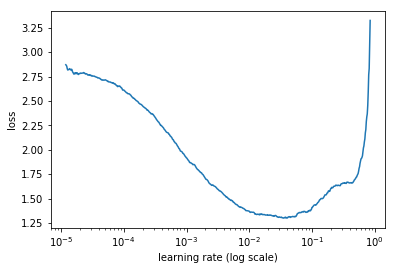

In [6]:
sgdm = Get_SGD_Momentum()
loss_sgdm = experiment(sgdm, find_lr=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.      1.1104  1.0742  0.6455]                           

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

[ 0.      1.184   1.0703  0.6384]                           
[ 1.      1.1274  1.0133  0.662 ]                           
[ 2.      1.1943  1.0936  0.6321]                           
[ 3.      1.1696  1.0542  0.6459]                           
[ 4.      1.1458  1.0218  0.6583]                           
[ 5.      1.1155  1.0048  0.6634]                           



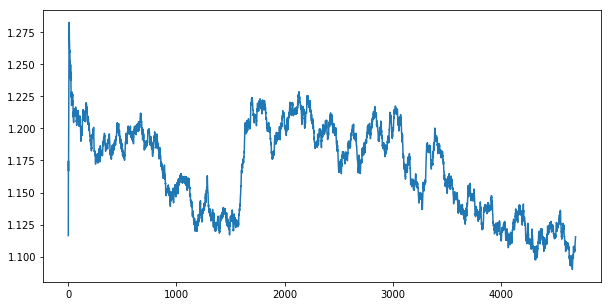

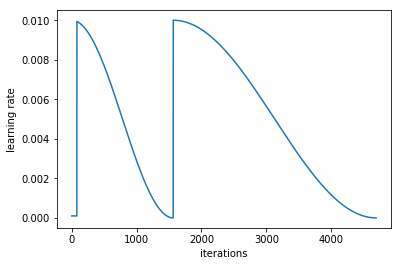

In [7]:
sgdm = Get_SGD_Momentum()
loss_sgdm = experiment(sgdm, lr=1e-2)
save_list('sgdm_loss.txt', loss_sgdm)

### Vanilla Adam with fixed weight decay and restarts

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 68%|██████▊   | 535/782 [00:09<00:04, 53.96it/s, loss=5.28]


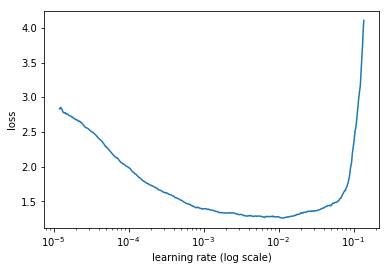

In [8]:
adam = Get_Adam()
loss_adam = experiment(adam, find_lr=True)

**Train**

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.      1.1831  1.1219  0.6208]                           

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

[ 0.      1.2717  1.1497  0.6168]                           
[ 1.      1.1943  1.059   0.6473]                           
[ 2.      1.255   1.1399  0.618 ]                           
[ 3.      1.2337  1.1003  0.6314]                           
[ 4.      1.2211  1.0695  0.6433]                           
[ 5.      1.175   1.0503  0.6506]                           



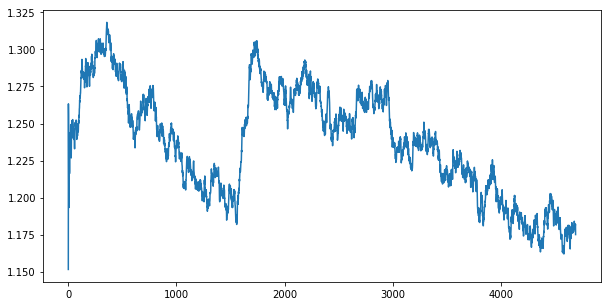

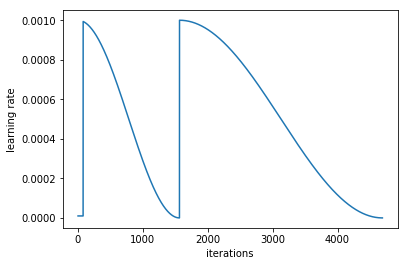

In [9]:
adam = Get_Adam()
loss_adam = experiment(adam, 1e-3)
save_list('adam_loss.txt', loss_adam)

### AdamW with dynamic weight decay and restarts

You are using the AdamW optimizer


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 69%|██████▉   | 543/782 [00:08<00:03, 61.85it/s, loss=5.24]


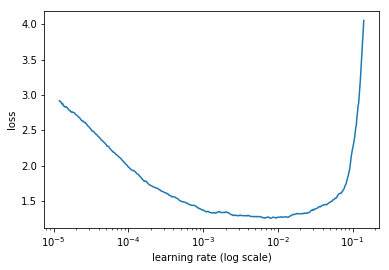

In [10]:
adamw = Get_AdamW()
loss_adamw = experiment(adamw, find_lr=True)

You are using the AdamW optimizer


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.      1.0251  0.9709  0.6622]                           

Now with precompute as False
You are using the AdamW optimizer


HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

[ 0.      1.0672  0.9425  0.6681]                           
[ 1.      1.0042  0.9037  0.6827]                            
[ 2.      1.0818  0.9283  0.6766]                           
[ 3.      1.006   0.9045  0.685 ]                            
[ 4.      0.9839  0.8782  0.6937]                            
[ 5.      0.9362  0.872   0.6942]                            



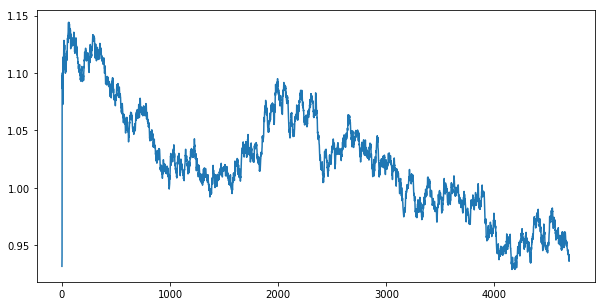

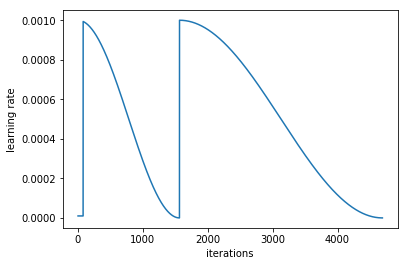

In [11]:
adamw = Get_AdamW()
loss_adamw = experiment(adamw, 1e-3, use_wd_schedule=True)
save_list('adam_lossw.txt', loss_adamw)

### SGDW with dynamic weight decay and restarts


You are using the SGDW optimizer


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|███████▉  | 623/782 [00:08<00:02, 70.03it/s, loss=5.32]


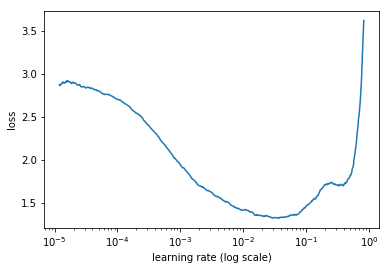

In [12]:
sgdw = Get_SGDW(0.9)
loss_sgdw = experiment(sgdw, find_lr=True)

You are using the SGDW optimizer


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.      1.0479  0.9856  0.6559]                           

Now with precompute as False
You are using the SGDW optimizer


HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

[ 0.      1.0516  0.9474  0.6658]                           
[ 1.      1.0252  0.9219  0.6763]                           
[ 2.      1.0622  0.9416  0.6703]                           
[ 3.      1.0425  0.9177  0.6795]                           
[ 4.      0.9985  0.8949  0.6844]                            
[ 5.      0.9849  0.8935  0.6848]                            



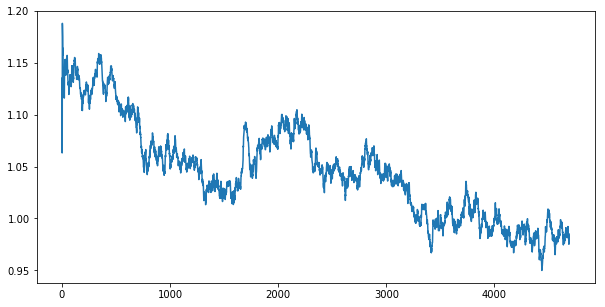

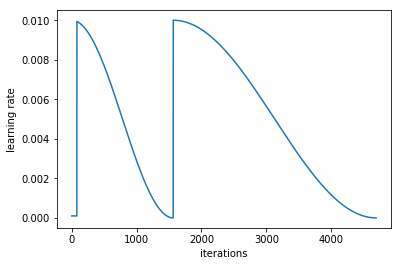

In [13]:
sgdw = Get_SGDW(0.9)
loss_sgdw = experiment(sgdw, 1e-2, use_wd_schedule=True)
save_list('loss_sgdw.txt', loss_sgdw)

### Plot all of them

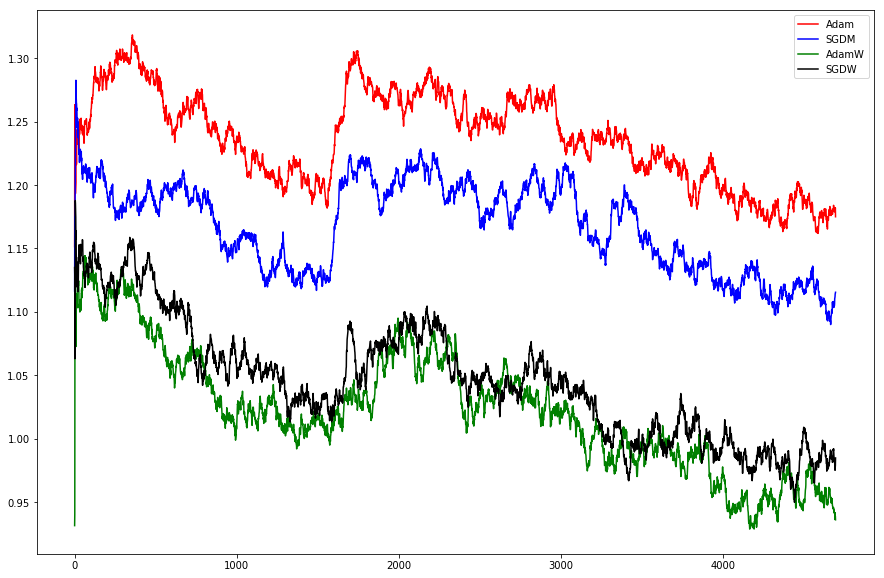

In [14]:
fig=plt.figure(figsize=(15, 10))
plt.plot(loss_adam, c='red', label='Adam')
plt.plot(loss_sgdm, c='blue', label='SGDM')
plt.plot(loss_adamw, c='green', label='AdamW')
plt.plot(loss_sgdw, c='black', label='SGDW')
plt.legend()
plt.show()

### Check with differential learning

In [15]:
"""
sgdw = Get_SGDW(0.9)
lr = 1e-2
wd = 0.025
loss_sgdw = experiment(sgdw, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_schedule=True)
save_list('loss_sgdw.txt', loss_sgdw)
"""

"\nsgdw = Get_SGDW(0.9)\nlr = 1e-2\nwd = 0.025\nloss_sgdw = experiment(sgdw, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_schedule=True)\nsave_list('loss_sgdw.txt', loss_sgdw)\n"

### Scratch

In [16]:
"""
adamw = Get_AdamW()

sz = 32
bs = 64
PATH = "/home/as/datasets/fastai.dogscats"
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

learn_adam = ConvLearner.pretrained(arch, data, precompute=True, opt_fn=adamw)
lrf=learn_adam.lr_find()
learn_adam.sched.plot()

lr = 1e-3
wds=0.025
cycle_len=1
cycle_mult=1
num_cycles = 1

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
learn_adam = ConvLearner.pretrained(arch, data, precompute=True, opt_fn=adamw
                                   )
learn_adam.fit(lr, 1, wds=wds)
print('Now with precompute as False')
learn_adam.precompute=False
learn_adam.fit(lr, num_cycles, wds=wds, cycle_len=cycle_len, cycle_mult=cycle_mult)
"""

'\nadamw = Get_AdamW()\n\nsz = 32\nbs = 64\nPATH = "/home/as/datasets/fastai.dogscats"\ntfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)\narch=resnet34\ndata = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)\n\nlearn_adam = ConvLearner.pretrained(arch, data, precompute=True, opt_fn=adamw)\nlrf=learn_adam.lr_find()\nlearn_adam.sched.plot()\n\nlr = 1e-3\nwds=0.025\ncycle_len=1\ncycle_mult=1\nnum_cycles = 1\n\ndata = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)\nlearn_adam = ConvLearner.pretrained(arch, data, precompute=True, opt_fn=adamw\n                                   )\nlearn_adam.fit(lr, 1, wds=wds)\nprint(\'Now with precompute as False\')\nlearn_adam.precompute=False\nlearn_adam.fit(lr, num_cycles, wds=wds, cycle_len=cycle_len, cycle_mult=cycle_mult)\n'